In [1]:
import numpy as np
from dsp.util import lcs
msg_bits = np.load('./data/msg_bits.npy').astype(np.int)

In [2]:
with open('./data/redsea_bits', 'r') as redsea:
    redsea_str = redsea.read().strip()
redsea_bitlist = list(map(int, redsea_str))
redsea_bits = np.array(redsea_bitlist, dtype=np.int)

In [3]:
redsea_bits.shape

(23084,)

In [4]:
BLUE, END = '\033[94m', '\033[0m'

def bit_diffs(bit1, bit2):
    bit1 = bit1.astype(int)
    bit2 = bit2.astype(int)
    lcs_arr, bit1_ind, bit2_ind = lcs(bit1, bit2)
    r_ind = set(bit1_ind)
    r_bits = [str(bit) if i in r_ind else BLUE + str(bit) + END for i, bit in enumerate(bit1)]
    r_s = ''.join(r_bits)

    m_ind = set(bit2_ind)
    m_bits = [str(bit) if i in m_ind else BLUE + str(bit) + END for i, bit in enumerate(bit2)]
    m_s = ''.join(m_bits)
    
    return r_s, m_s

**So it seems that there is still an issue with physical layer. Let's compare what Redsea decodes at that level to what we have.**

In [5]:
import numpy as np
from utils import read_real, plot_some, plot_several

In [6]:
redsea_demod = read_real('../../sdr/dump_samples', np.float32)
redsea_demod.shape

(3324132,)

In [7]:
rds_demod = np.load('./data/rds_demod.npy')
rds_demod.shape

(3323875,)

In [8]:
from dsp.agc import AGC
gain = 0.08
alpha = 0.11
agc = AGC(gain, alpha)
msg_agc = agc.run(rds_demod)

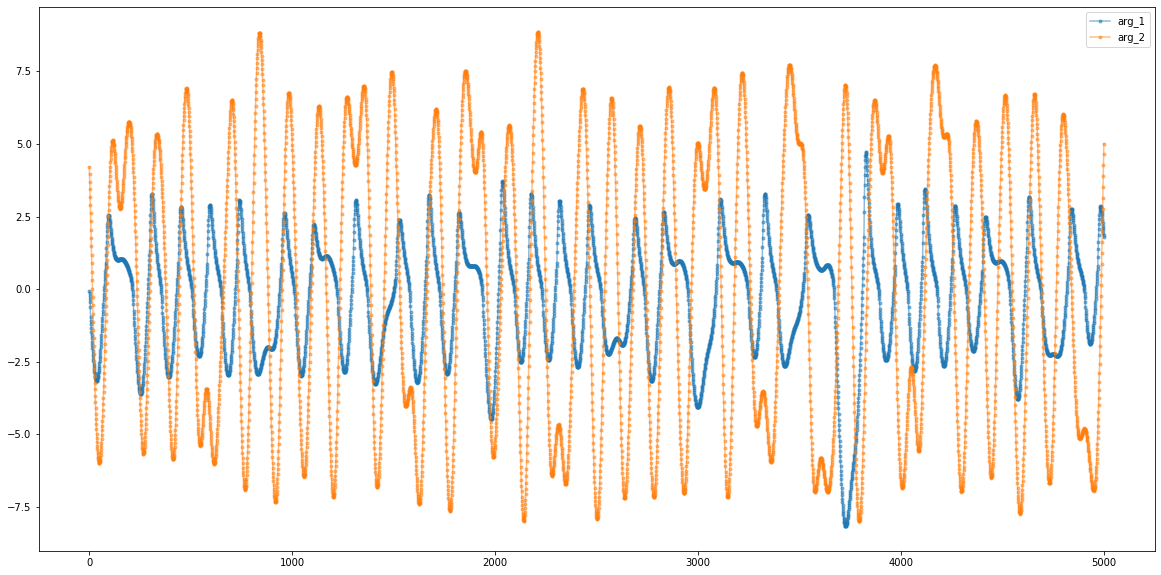

In [9]:
plot_some((msg_agc[257:], 5 * redsea_demod), 72 * 7082, 5000, '.-')

**Now let us try to use our symbol synchronizer on signal obtained from Redsea guts.**

In [56]:
from dsp.decoding import SymbolDecoder, BiphaseDecoder, BlockGenerator

symbol_rate = 2375
sample_rate = 171000 
samples_per_symbol = sample_rate / symbol_rate
output_samples_per_symbol = 1
symbol_delay = 3
filterbank_size = 32
matched_filter_rolloff = 0.8
Bn = 0.01

sd = SymbolDecoder(
    sample_rate,
    samples_per_symbol,
    output_samples_per_symbol,
    nco_gain=100,
    symbol_delay=symbol_delay,
    filterbank_size=filterbank_size, 
    matched_filter_rolloff=matched_filter_rolloff,
    Bn=Bn
)

redsea_values = sd.run(redsea_demod.astype(np.double))
symbols, xs, taus, tau_deltas = redsea_values

bd = BiphaseDecoder()
redsea_bits = bd.run(symbols)

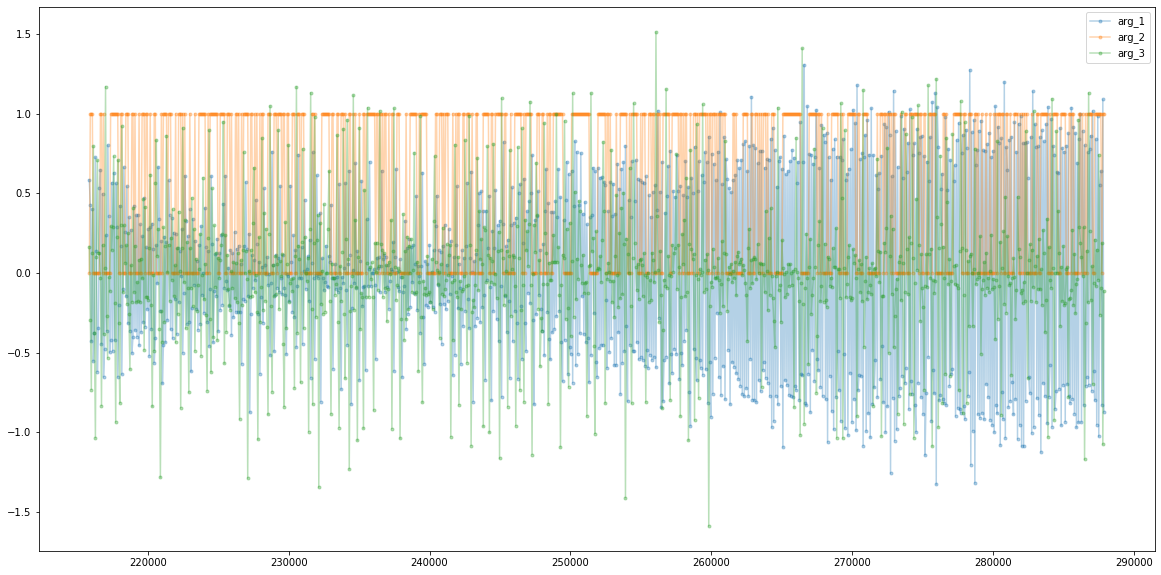

In [63]:
start_s = 3000
count_s = 1000

#start_s = np.searchsorted(xs, start)
#count_s = np.searchsorted(xs, start + count) - start_s

plot_several([ 
    (xs - 200, 10 * symbols, (start_s, count_s)),   # why 200??
    (xs - 200, redsea_bits, (start_s, count_s)),
    (xs - 200, redsea_demod[::72], (start_s, count_s)),
    # (xs, taus, (start_s, count_s)),
    # (xs, tau_deltas / 35, (start_s, count_s))
], '.-')

In [12]:
import pandas as pd
df = pd.DataFrame(redsea_bits)
s = df.rolling(10).sum()
print(list(df[np.isclose(s, 0)].index))

[159, 160, 161, 162, 163, 164, 165, 166, 167, 373, 374, 375, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1114, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1946, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 5435, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6187, 7328, 7329, 7330, 7331, 7481, 7482, 7483, 7484, 7628, 7629, 7630, 7631, 7632, 7633, 7634, 7635, 7636, 7637, 7654, 7655, 7742, 7743, 7744, 7745, 7746, 7834, 7835, 7836, 7837, 7838, 7839, 7840, 7841, 7842, 7843, 7861, 7862, 8356, 8357, 8664, 8665, 8666, 8667, 8668, 8669, 8670, 8671, 8672, 8690, 8691, 8692, 8832, 8833, 8987, 8988, 8989, 8990, 8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000, 9493, 9494, 9495, 9496, 9497, 9498, 9499, 9500, 9501, 10096, 10236, 10237, 10238, 10239, 10310, 10311, 10650, 10651, 10652, 10653, 10753, 10754, 10755, 12060, 12402, 12403, 12404, 12405, 13379, 13423, 13424, 13425, 13426, 13427, 13428, 13429, 13430, 13735, 13736, 

In [13]:
redsea_symbols = read_real('../../redsea/dump_symbols', np.float32)
redsea_symbols.shape

(46166,)

In [14]:
redsea_biphase_bits = read_real('../../redsea/dump_biphase_output_symbols', np.float32)

In [15]:
redsea_biphase_bits.shape

(23083,)

In [16]:
my_biphase_bits = bd.run(redsea_symbols.astype(np.double))

In [17]:
mbb_s, rbb_s = bit_diffs(redsea_bits, redsea_biphase_bits)

In [18]:
print(mbb_s)

0111110000011111111101010101001111001101000010010001111101011011011100011000011100010001100110000100011111110000011000001101011011101100001101111111110000000000000000001111111100000000100101111101110000000110100000011100000110011100000110100101111100110010100101101011110011111111111010101010110000100011011111010110111010011001001000010010110111011011110111000001000000000000111111110000000010010111110111000000011010000001111111100110001111100000000010110001100111001000110000011000111011111011001100011101110000000110100000011111111001100011100011010001100111011011101011000001000100011110110001010111101111011100000001101000000111000001100111000001101001011111001100101001011010111100111111111110101010101100001000111111100101111110000000011001110011000101110011101110111010100010011001101101011001001100011100000010001111111001011111100000000110011101011100011011001110110010001100000101111000011001100111111100110000100011111110010111111000001110011000111100110010100011111111000000000000000000

In [19]:
print(rbb_s)

0111000111110001010000101111101100000100111100110110101001111101110001011010111001100000110011000010001111111000001100000100101101000101100110011111111000000000000000000111111110000000010010111110111000000011010000001110000011001110000011010010111110011001010010110101111001111111111101010101011000010001111111101011011100000010101100010001011001100001111011100000000000000000011111111000000001001011111011100000001101000000111111110011000111110000000001011000110011100100011000001100011101111101100110001110111000000011010000001111111100110001110001101000110011101101110101100000100010001111011000101011110111101110000000110100000011100000110011100000110100101111100110010100101101011110011111111111010101010110000100011111110010111111000000001100111001100010111001110111011101010001001100110110101100100110001110000001000111111100101111110000000011001110101110001101100111011001000110000010111100001100110011111110011000010001111111001011111100000111001100011110011001010001111111100000000000000000

In [20]:
gen = BlockGenerator()
blocks = gen.find_blocks(np.logical_xor(redsea_bits[1:], redsea_bits[:-1]).astype(np.int))
[(j, b) for j, (i, b) in enumerate(blocks) if i == 0]

('SYNCED: ', 191)
('LOST SYNC: ', 3337)
('SYNCED: ', 3412)
('LOST SYNC: ', 4842)
('SYNCED: ', 4890)
('LOST SYNC: ', 6138)
('SYNCED: ', 6315)
('LOST SYNC: ', 7511)
('SYNCED: ', 7712)
('LOST SYNC: ', 8934)
('SYNCED: ', 9473)
('LOST SYNC: ', 10695)
('SYNCED: ', 10973)
('LOST SYNC: ', 12169)
('SYNCED: ', 13636)
('LOST SYNC: ', 14884)
('SYNCED: ', 15055)
('LOST SYNC: ', 16251)
('SYNCED: ', 18438)
('LOST SYNC: ', 19634)
('SYNCED: ', 20480)
('LOST SYNC: ', 21676)
('SYNCED: ', 22926)
('LOST SYNC: ', 22926)


[(0, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (5, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (9, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (13, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (17, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (21, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (25, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (29, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (33, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (37, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (41, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (45, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (49, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (54, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (58, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1])),
 (62, array([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

In [21]:
real_blocks = gen.find_blocks(redsea_biphase_bits.astype(np.int))
[(j, b) for j, (i, b) in enumerate(real_blocks) if i == 0]

('SYNCED: ', 674)
('LOST SYNC: ', 1870)
('SYNCED: ', 2862)
('LOST SYNC: ', 4110)
('SYNCED: ', 4350)
('LOST SYNC: ', 5650)
('SYNCED: ', 6190)
('LOST SYNC: ', 7412)
('SYNCED: ', 7854)
('LOST SYNC: ', 9102)
('SYNCED: ', 10142)
('LOST SYNC: ', 11364)
('SYNCED: ', 12339)
('LOST SYNC: ', 13561)
('SYNCED: ', 13986)
('LOST SYNC: ', 15208)
('SYNCED: ', 15478)
('LOST SYNC: ', 16726)
('SYNCED: ', 17766)
('LOST SYNC: ', 19924)
('SYNCED: ', 20279)
('LOST SYNC: ', 21475)
('SYNCED: ', 21718)
('LOST SYNC: ', 22992)
('SYNCED: ', 23083)
('LOST SYNC: ', 23083)


[(9, array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1])),
 (13, array([0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1])),
 (35, array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1])),
 (37, array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1])),
 (39, array([0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1])),
 (43, array([0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1])),
 (68, array([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]))]